<h1 style="color:#27469c">Preprocessing of Kissam Cooling Towers 1 and 2 data</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import preprocessor
import numpy as np

import warnings
warnings.filterwarnings('ignore')

rootpath = ".."

In [2]:
# load cooling tower data
df = pd.read_csv(f'{rootpath}/data/kissam/2661_x.csv', index_col='time')
df.index = pd.to_datetime(df.index, utc='True')

for df_name in ["1510_x", "1509_2", "1482_1", "4684_1", "4685_2"]:
    more_data = pd.read_csv(f'{rootpath}/data/kissam/{df_name}.csv', index_col='time')
    more_data.index = pd.to_datetime(df.index, utc='True')
    df = pd.concat([df, more_data], axis=1)

df.drop(columns=df.filter(like='generated', axis=1).columns, inplace=True)
df = df.loc[:,~df.columns.duplicated()]

In [3]:
df1 = df.loc[:, ~df.columns.str.contains("2")]
df2 = df.loc[:, ~df.columns.str.contains("1")]

In [4]:
df1.columns

Index(['CT_1.TempCondIn', 'CT_1.TempCondOut', 'TempAmbient', 'TempWetBulb',
       'Setpoint_Existing', 'CT_1.PerFreqFan', 'CT_1.PowFan', 'CT_1.StatusFan',
       'CH_1.PowChi', 'CT_1.FlowCond', 'CT_1.PerFreqConP', 'CT_1.PowConP',
       'CT_1.PressDiffCond', 'Setpoint_Python', 'CH_1.Tonnage',
       'Chiller_1 chillerTotalKw', 'Chiller_1_Tons', 'CH1_KW_per_Ton',
       'Chiller_1 chillerCondEnteringWaterTemp',
       'Chiller_1 chillerEvapEnteringWaterTemp',
       'Chiller_1 chillerEvapLeavingWaterTemp',
       'Chiller_1 chillerEvapWaterFlow', 'Chiller_1 chillerStatus',
       'Chiller_1 outdoorAirTemp', 'Chiller_1 runningCapacity',
       'Chiller_1 chillerCondLeavingWaterTemp',
       'Chiller_1 chwSupplyTempSetpoint', 'Chiller_1 enabled',
       'Chiller_1 inAlarm', 'Chiller_1 outdoorAirHumidity',
       'Chiller_1 wetBulbTemperature', 'Chiller_1 tonnage'],
      dtype='object')

<h2 style="color:#27469c">Rename columns and separate the 2 cooling towers' data</h2>

In [5]:
for i in [1,2]:
    renaming = {}
    renaming["TempWetBulb"] = "TempWetBulb"
    renaming["TempAmbient"] = "TempAmbient"
    renaming[f"CT_{i}.TempCondIn"] = "TempCondIn"
    renaming[f"CT_{i}.TempCondOut"] = "TempCondOut"
    renaming[f"CT_{i}.PerFreqFan"] = "PerFreqFan"
    renaming[f"CT_{i}.PowFan"] = "PowFan"
    renaming[f"CT_{i}.FlowCond"] = "FlowCond"
    renaming[f"CT_{i}.PerFreqConP"] = "PerFreqConP"
    renaming[f"CT_{i}.PowConP"] = "PowConP"
    renaming[f"CT_{i}.PressDiffCond"] = "PressDiffCond"
    renaming[f"CH_{i}.PowChi"] = "PowChi"
    renaming[f"CH_{i}.Tonnage"] = "Tonnage"
    renaming[f"Chiller_{i} chillerEvapEnteringWaterTemp"] = "TempEvapIn"
    renaming[f"Chiller_{i} chillerEvapLeavingWaterTemp"] = "TempEvapOut"
    renaming[f"Chiller_{i} chillerEvapWaterFlow"] = "FlowEvap"
    renaming[f"Chiller_{i} outdoorAirHumidity"] = "PerHumidity"
    columns_to_keep = list(renaming.values())
    if i==1:
        df1.rename(renaming, inplace=True, axis=1)
        df1 = df1[columns_to_keep]
    else:
        df2.rename(renaming, inplace=True, axis=1)
        df2 = df2[columns_to_keep]

<h2 style="color:#27469c">Cooling Tower 1</h2>

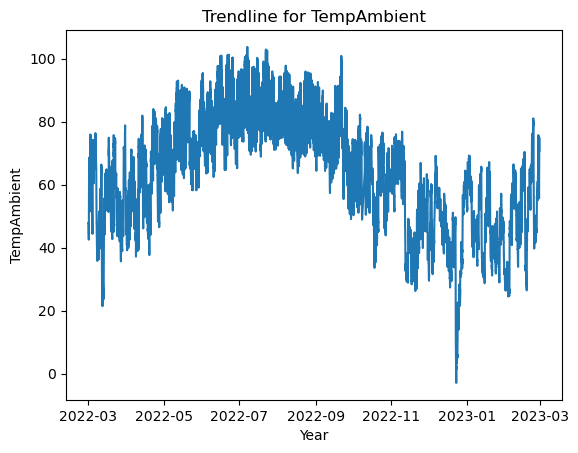

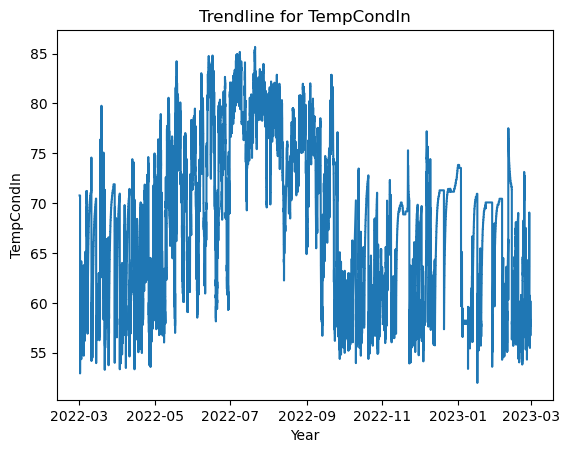

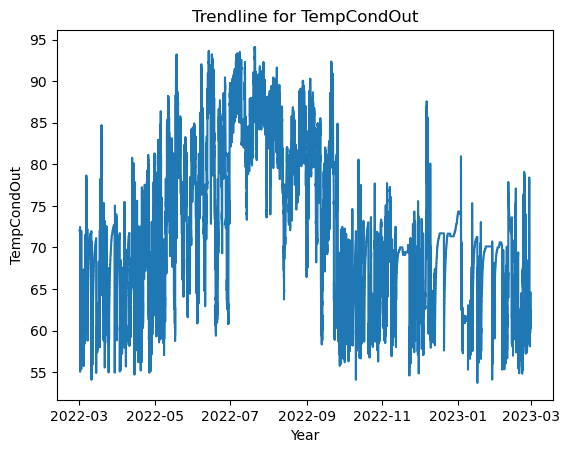

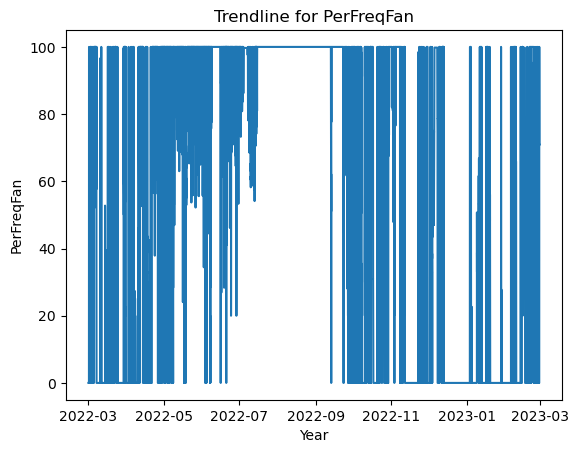

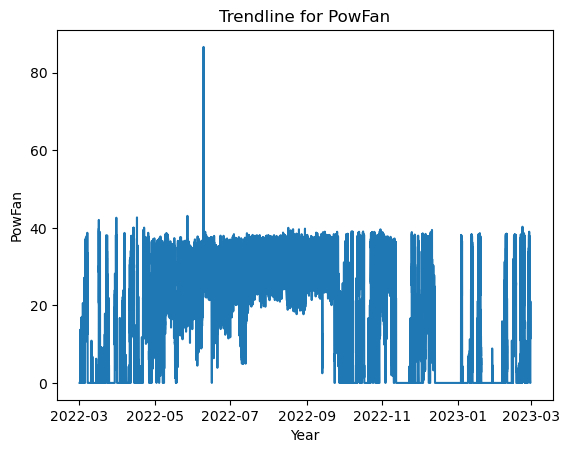

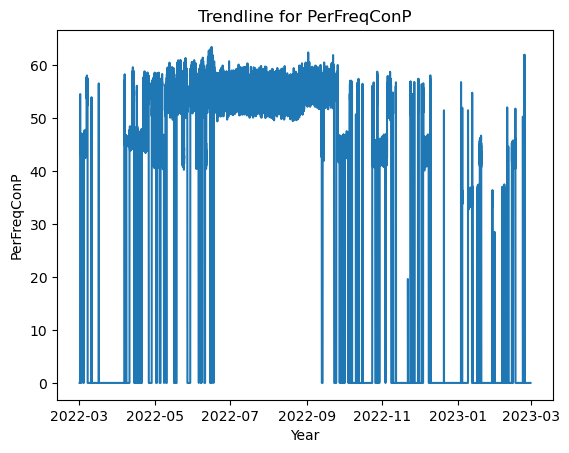

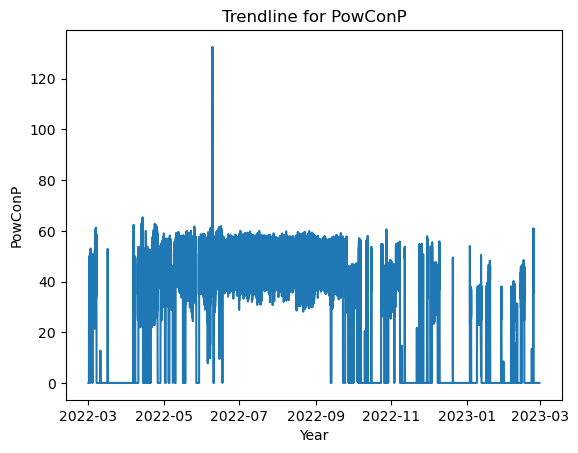

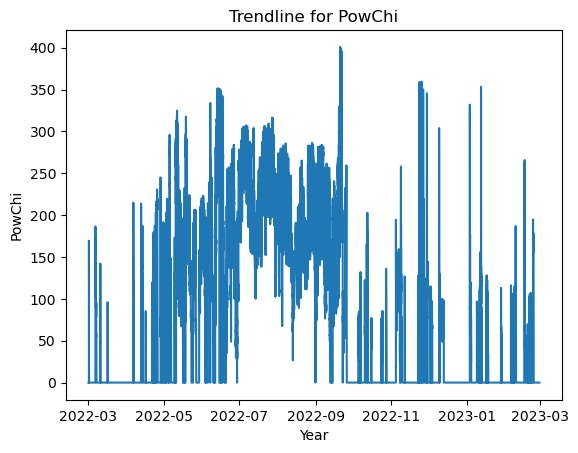

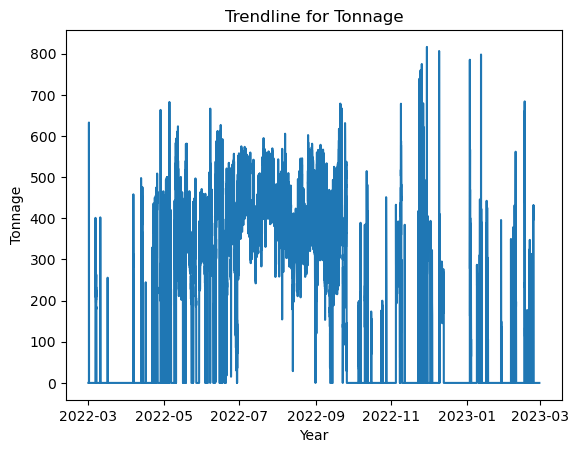

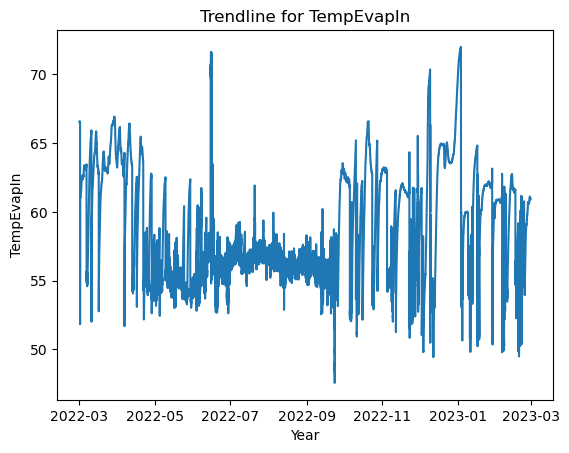

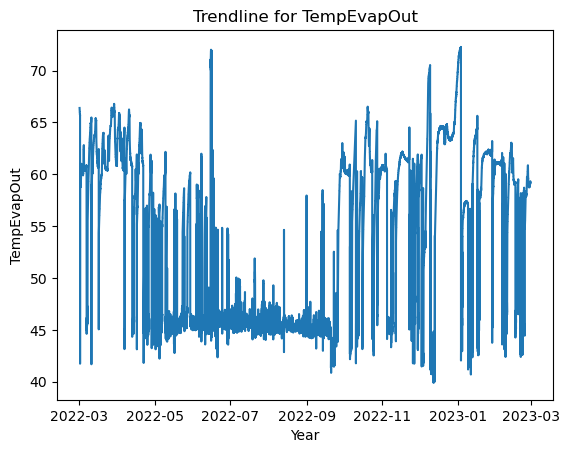

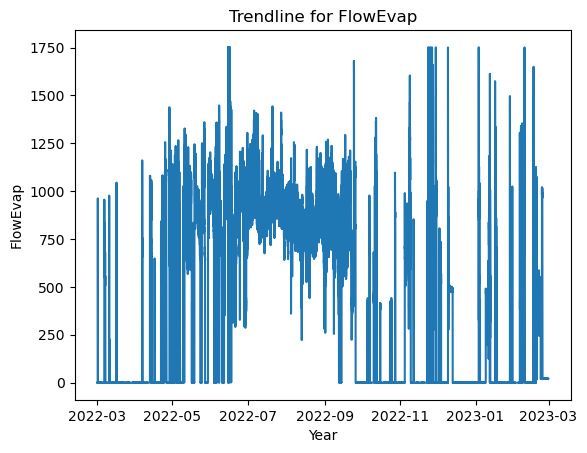

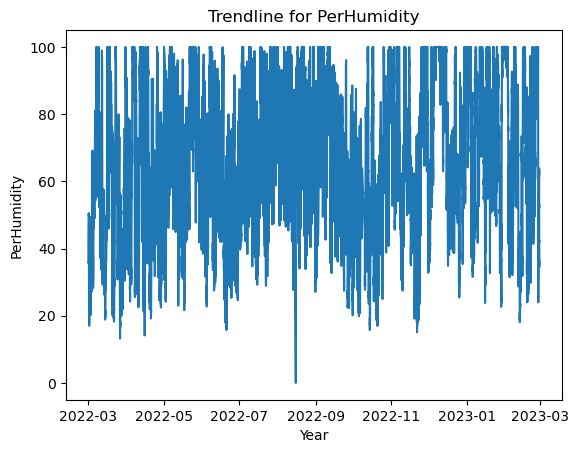

In [7]:
# Iterate through the columns and create a separate figure for each
for column in df1.columns[1:]:
    plt.figure()  # Create a new figure
    plt.plot(df1.index, df1[column])
    plt.title(f'Trendline for {column}')
    plt.xlabel('Year')
    plt.ylabel(column)

plt.show()

In [6]:
initial_data_size = df1.shape[0]

# drop columns with no data (FlowCond)
df1 = df1.dropna(axis=1, how="all")

# replace 0.0 in enviroment columns with null
env_cols = ["TempWetBulb", "TempCondIn", "TempEvapOut", "TempEvapIn", "TempAmbient", "PerHumidity"]
df1[env_cols].replace({0.0 : np.nan}, inplace=True)

print(df1.isna().sum() / df1.shape[0])

df1 = df1.dropna()
print(f"After missing data removal, we are left with {df1.shape[0]} rows out of {initial_data_size}.")

TempWetBulb    0.009555
TempAmbient    0.009555
TempCondIn     0.009555
TempCondOut    0.009555
PerFreqFan     0.009555
PowFan         0.016032
PerFreqConP    0.009555
PowConP        0.016032
PowChi         0.009555
Tonnage        0.010117
TempEvapIn     0.009555
TempEvapOut    0.009555
FlowEvap       0.009555
PerHumidity    0.009555
dtype: float64
After missing data removal, we are left with 103236 rows out of 104976.


In [12]:
# add season, dayOfWeek and hourOfDay columns
preprocessor.create_season_col(datadf=df1, season_col_name="Season")
df1["DayOfWeek"] = df1.index.weekday
df1['HourOfDay'] = df1.index.hour

s2 = set(df1.columns)
s1 = set(['FlowEvap', 'PerHumidity', 'TempAmbient', 'TempCondIn',
       'TempCondOut', 'TempEvapIn', 'TempEvapOut', 'TempWetBulb',
       'PerFreqConP', 'Tonnage', 'Season', 'DayOfWeek', 'HourOfDay',
       'PerFreqFan', 'EnergyConsumption'])
print(s2 - s1)
print(s1-s2)

# target

df1['EnergyConsumption'] = df1["PowFan"] + df1["PowConP"] + df1["PowChi"] # note that this summation is different for ESB
df1.drop(columns=["PowFan", "PowConP", "PowChi"], inplace=True)

# # save tower 1 preprocessed data
df1.sort_index(axis=1).to_csv(f'{rootpath}/data/kissam/kissam1_preprocessed.csv')

{'PowConP', 'PowFan', 'PowChi'}


<h2 style="color:#27469c">Replicate for Cooling Tower 2</h2>

In [13]:
# missing data
initial_data_size = df2.shape[0]
df2 = df2.dropna(axis=1, how="all")
df2[env_cols].replace({0.0 : np.nan}, inplace=True)
print(df2.isna().sum() / df2.shape[0])
df2 = df2.dropna()
print(f"After missing data removal, we are left with {df2.shape[0]} rows out of {initial_data_size}.")

# add season, dayOfWeek and hourOfDay columns
preprocessor.create_season_col(datadf=df2, season_col_name="Season")
df2["DayOfWeek"] = df2.index.weekday
df2['HourOfDay'] = df2.index.hour
df2['EnergyConsumption'] = df2["PowFan"] + df2["PowConP"] + df2["PowChi"] # note that this summation is different for ESB
df2.drop(columns=["PowFan", "PowConP", "PowChi"], inplace=True)

# save tower 2 preprocessed data
df2.sort_index(axis=1).to_csv(f'{rootpath}/data/kissam/kissam2_preprocessed.csv')

TempWetBulb    0.009555
TempAmbient    0.009555
TempCondIn     0.009555
TempCondOut    0.009555
PerFreqFan     0.009555
PowFan         0.016032
PerFreqConP    0.009555
PowConP        0.016032
PowChi         0.009555
Tonnage        0.010117
TempEvapIn     0.009555
TempEvapOut    0.009555
FlowEvap       0.009555
PerHumidity    0.009555
dtype: float64
After missing data removal, we are left with 103236 rows out of 104976.


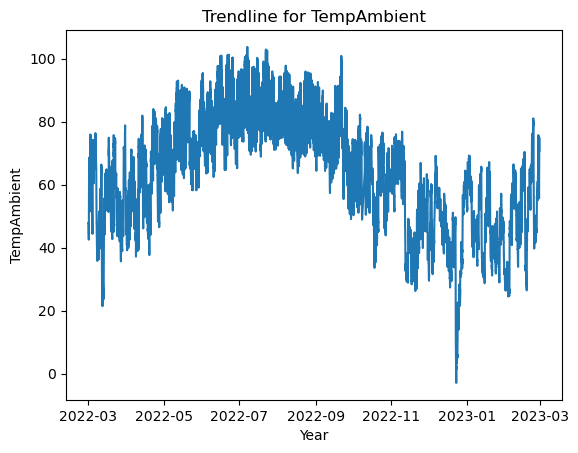

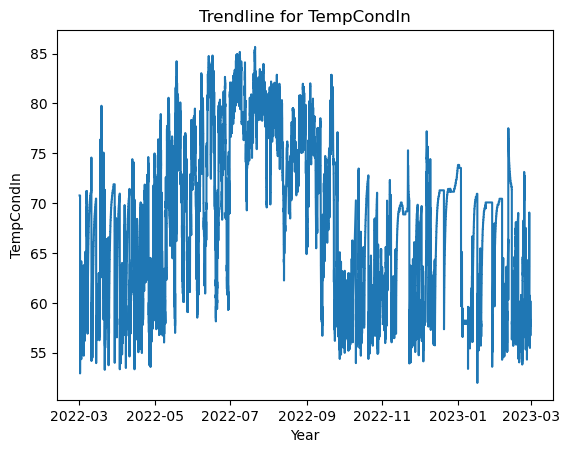

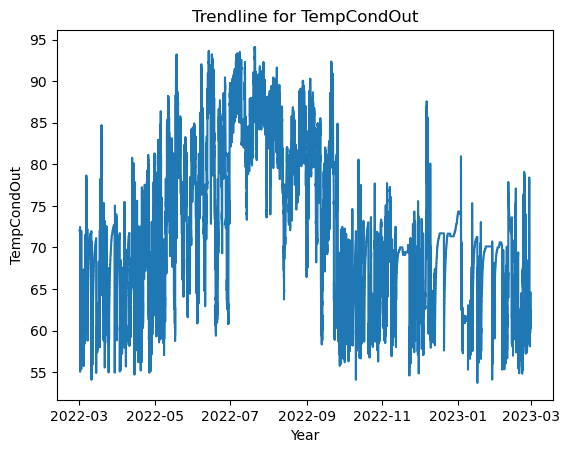

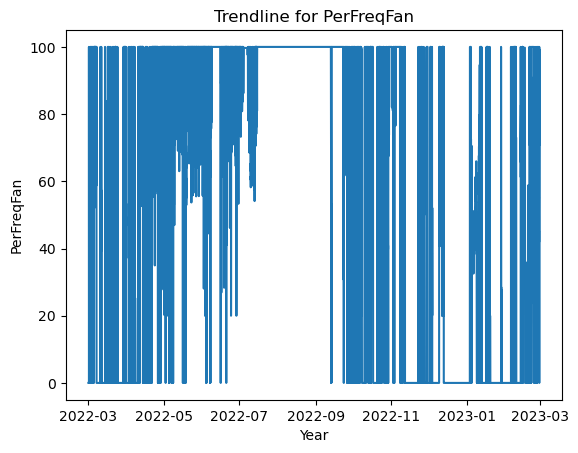

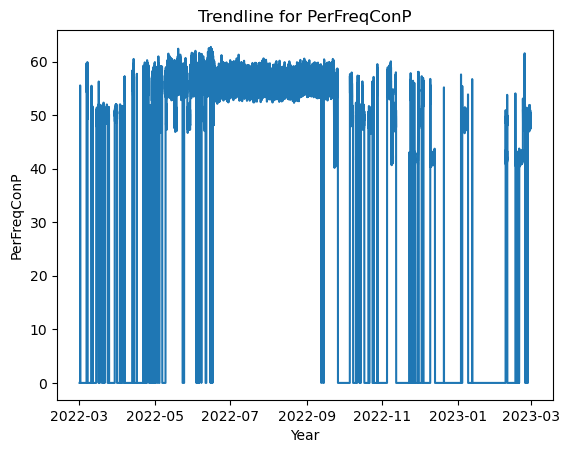

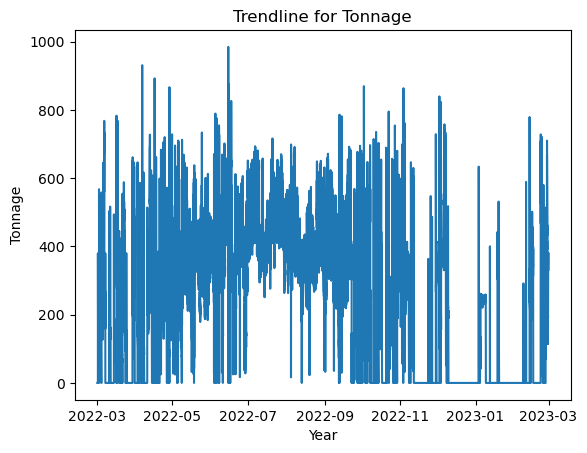

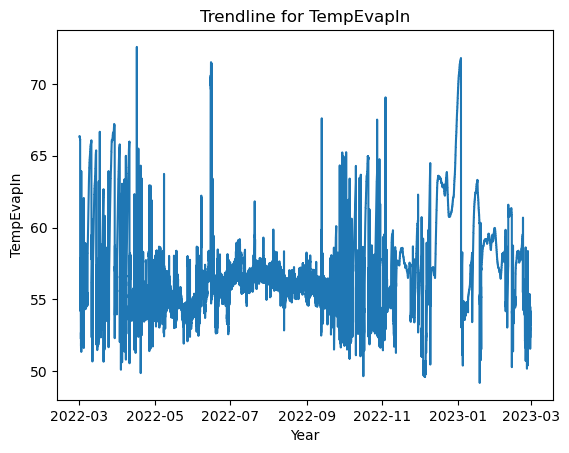

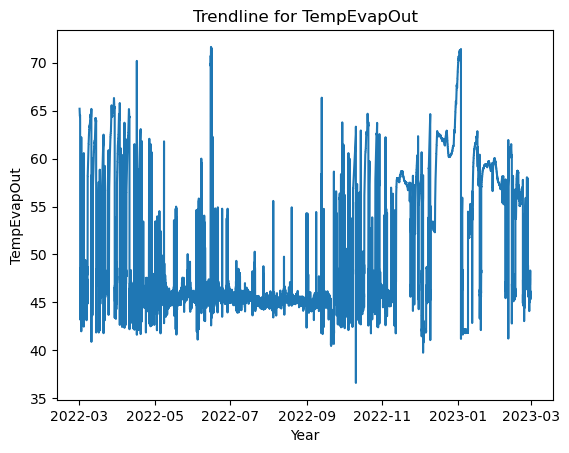

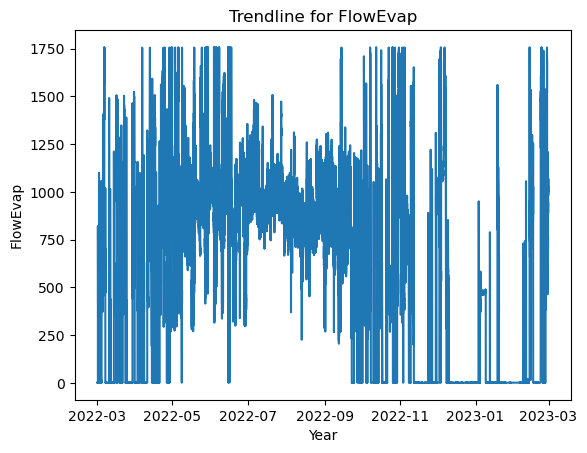

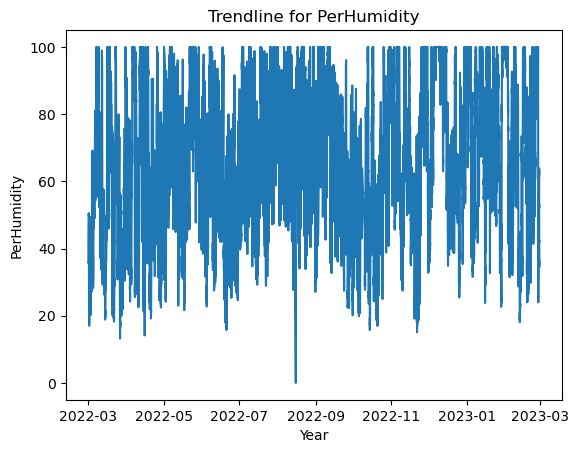

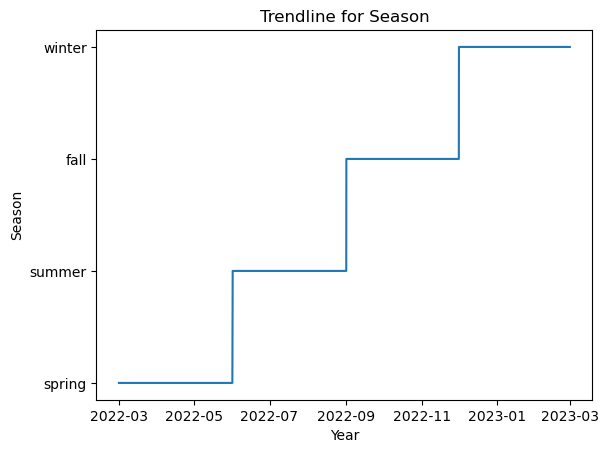

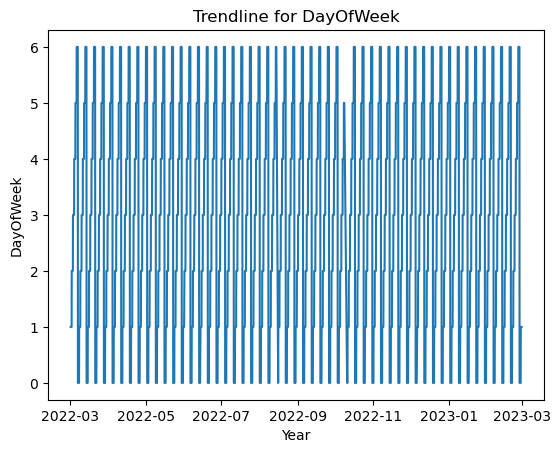

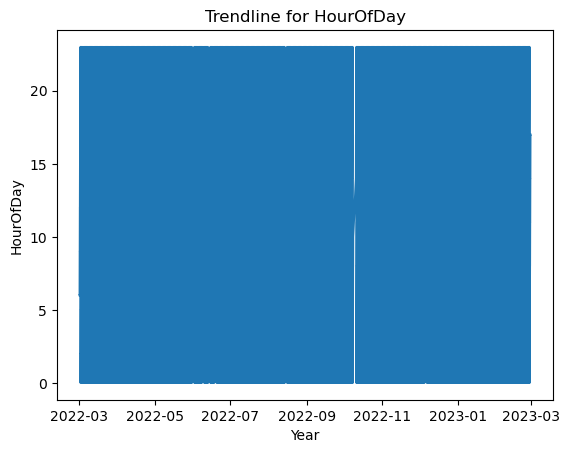

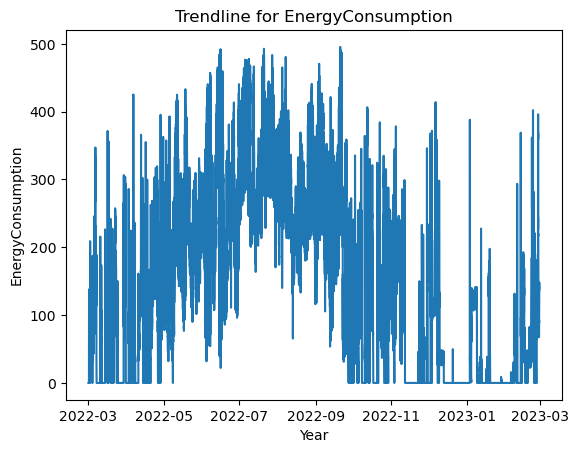

In [14]:
# Iterate through the columns and create a separate figure for each
for column in df2.columns[1:]:
    plt.figure()  # Create a new figure
    plt.plot(df2.index, df2[column])
    plt.title(f'Trendline for {column}')
    plt.xlabel('Year')
    plt.ylabel(column)

plt.show()